In [80]:
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from pathlib import Path
import mediapipe as mp
import numpy as np
import cv2

In [81]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
PL = mp_pose.PoseLandmark

In [82]:
PROJ_DIR = Path('/Users/lyronctk/Desktop/projects/trainer')
TEST_IM_PATH = PROJ_DIR / 'data/test_im.png'

REF_IM_DIR = PROJ_DIR / 'data/ruleset_references'
REF = {
    'proper': REF_IM_DIR / 'ref_proper.png',
    'squat': REF_IM_DIR / 'ref_squat.png',
    'rounded': REF_IM_DIR / 'ref_rounded.png',
    'crooked': REF_IM_DIR / 'ref_crooked.png',
    'lockout': REF_IM_DIR / 'ref_lockout.png'
}
LABEL_STR_MAP = {
    'proper': 1,
    'squat': 2,
    'rounded': 3,
    'crooked': 4,
    'lockout': 5
}

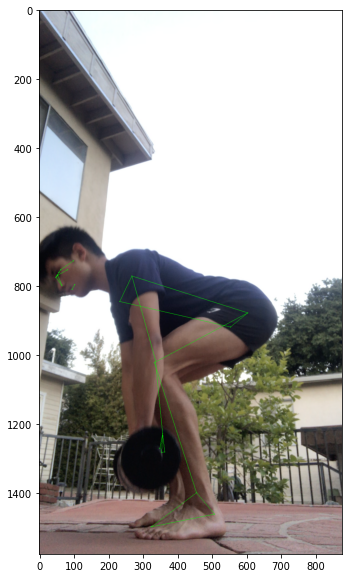

In [83]:
im_path = REF_PROPER

blaze = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)
image = cv2.imread(str(im_path))

blaze_out = blaze.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
if not blaze_out.pose_landmarks:
    raise ValueError(f"Pose landmarks not found for {im_path}.")

annotated_image = image.copy()
mp_drawing.draw_landmarks(
    image=annotated_image,
    landmark_list=blaze_out.pose_landmarks,
    connections=mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=drawing_spec,
    connection_drawing_spec=drawing_spec) 

rgb = annotated_image[:,:,::-1]
fig = plt.figure()
fig.set_size_inches(25, 10)
plt.imshow(rgb)

In [84]:
landmarks_of_interest = [
    PL.LEFT_SHOULDER,
    PL.RIGHT_SHOULDER,
    PL.LEFT_WRIST,
    PL.RIGHT_WRIST,
    PL.LEFT_HIP,
    PL.RIGHT_HIP,
    PL.LEFT_KNEE,
    PL.RIGHT_KNEE,
    PL.LEFT_ANKLE
]

In [85]:
def coords(results, landmark):
    lms = results.pose_landmarks.landmark
    return np.array([lms[landmark].x, lms[landmark].y, lms[landmark].z])

In [86]:
def pose_estimation(im_path, show_annotated=False):
    blaze = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)
    image = cv2.imread(str(im_path))

    blaze_out = blaze.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not blaze_out.pose_landmarks:
        raise ValueError(f"Pose landmarks not found for {im_path}.")

    if show_annotated:
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=blaze_out.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=drawing_spec) 
    
        rgb = annotated_image[:,:,::-1]
        fig = plt.figure()
        fig.set_size_inches(25, 10)
        plt.imshow(rgb)
    return blaze_out

In [87]:
def extract_features(im_path, show_annotated=False):
    blaze_out = pose_estimation(im_path, show_annotated)
    return np.concatenate([coords(blaze_out, loi) for loi in landmarks_of_interest])

In [88]:
extract_features(REF['crooked'])

array([ 0.3860355 ,  0.57934988, -0.36166534,  0.36494023,  0.61321127,
        0.32168412,  0.24251983,  0.83592182, -0.32966384,  0.24894309,
        0.83698237,  0.18502888,  0.72912967,  0.61076152, -0.19871835,
        0.69930285,  0.63648808,  0.19880378,  0.4329012 ,  0.66854119,
       -0.51968002,  0.41919303,  0.69062531,  0.12939571,  0.54551446,
        0.8521353 , -0.3328982 ])

In [89]:
X, y = [], []
for label, im_path in REF.items():
    X.append(extract_features(REF[label]))
    y.append(label)
X = np.stack(X, axis=0)
y = np.array([LABEL_STR_MAP[label] for label in y])

In [90]:
X

array([[ 0.30618787,  0.48861009, -0.35574993,  0.26656044,  0.53591585,
         0.26452079,  0.40816289,  0.77915895, -0.16272227,  0.31850225,
         0.77024424,  0.19652574,  0.68926841,  0.55677748, -0.18119584,
         0.63190383,  0.58271432,  0.18133695,  0.38069776,  0.6484105 ,
        -0.29805583,  0.33823067,  0.6738385 ,  0.11732272,  0.51956558,
         0.88706422, -0.16961955],
       [ 0.33954781,  0.45110375, -0.3906585 ,  0.24885431,  0.51266849,
         0.11321943,  0.36538678,  0.75889963, -0.31747681,  0.27011845,
         0.76419544,  0.17694464,  0.64832574,  0.61443132, -0.16375382,
         0.55055547,  0.630678  ,  0.16394521,  0.29870346,  0.60763884,
        -0.3224237 ,  0.22740044,  0.64496839,  0.18846546,  0.46041235,
         0.80463827,  0.00630639],
       [ 0.3083975 ,  0.48463407, -0.6914655 ,  0.2445769 ,  0.54504091,
         0.06218184,  0.37545469,  0.80264056, -0.84565574,  0.29832578,
         0.81419384, -0.25378352,  0.72044009,  0.5574

In [91]:
y

array([1, 2, 3, 4, 5])

In [95]:
clf = MLPClassifier(random_state=1, 
                    hidden_layer_sizes=(32),
                    max_iter=500)
clf.fit(X, y)

/Users/lyronctk/miniconda3/envs/trainer/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=32, max_iter=500, random_state=1)

In [97]:
clf.predict(X)

array([1, 2, 3, 4, 5])

In [98]:
clf.predict_proba(X)

array([[8.14525060e-01, 9.49810640e-02, 6.83557832e-03, 7.80082701e-02,
        5.65002800e-03],
       [9.76048882e-02, 8.17975442e-01, 5.30079206e-03, 7.77215302e-02,
        1.39734718e-03],
       [1.19703570e-03, 3.76167822e-03, 9.64537600e-01, 3.01715229e-02,
        3.32162753e-04],
       [7.88160225e-02, 7.17409116e-02, 2.29848979e-02, 8.16952942e-01,
        9.50522581e-03],
       [8.59603861e-03, 1.33690002e-05, 1.24155486e-03, 1.45284228e-02,
        9.75620615e-01]])